In [15]:
###############################################
# Get some imports
%run RequiredImports.py

rng = np.random.RandomState(333)

###############################################
# Choose the regression model (note: we assume loss is squared)

#########################
# USE A K-NN REGRESSOR
#########################
ferm_model = KNeighborsRegressor(n_neighbors = 1)  # watch out for the warm_start flag in certain models
fhat_model = ferm_model
xParams = range(12, 0, -1) # k
xParamName = 'n_neighbors'

#########################
# USE A TREE 
#########################
#ferm_model = DecisionTreeRegressor(max_depth = 5)
#fhat_model = ferm_model
#fhat_model = DecisionTreeRegressor(max_depth = 3, splitter='random')
#xParams = range(1, 16, 1) # depths of a tree
#xParamName = 'max_depth'


###############################################


#########################
# DEFINE SOME VARIABLES
#########################

numTrials = 500

SIGMA=3

numParams = len(xParams)

optim  = np.empty(numParams)
estim  = np.empty(numParams)
approx = np.empty(numParams)
bayes = np.empty(numParams)

estimvar  = np.empty(numParams)
estimbias = np.empty(numParams)

Risk_fhat = np.empty((numParams, numTrials))
Risk_Efhat = np.empty((numParams))

Risk_ferm = np.empty((numParams, numTrials))

Risk_fstar = 999*np.ones((numParams))

ERisk_fhat = np.empty(numParams)
ERisk_ferm = np.empty(numParams)

###############################################

In [16]:
#########################
# DEFINE THE TOY FUNCTION 
#########################

def trueFunction(x): return x + 5*np.sin(2*x)

def getSample(n=100):
    X = 15*rng.rand(n, 1) # Generate n random points [0,15]
    y = np.add( trueFunction(X), rng.normal(0.0, SIGMA, n).reshape(n, 1)  ) # Add some noise
    return X, y

PX = np.arange(0.0, 15, 0.001)[:, np.newaxis] # generate 15000 points, the 'full' distribution
PY = np.add( trueFunction(PX), rng.normal(0.0, SIGMA, 15000).reshape(15000, 1)  ) # Add some noise

###############
#### DEFINE y^* (Bayes model)
###############

R_ystar = mean_squared_error( trueFunction(PX), PY )


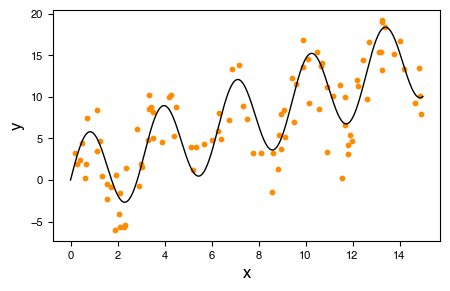

In [17]:
###################################################
# PLOT THE TOY FUNCTION THAT WE WILL BE PREDICTING        
###################################################

plt.figure(figsize=[5,3])

tmpPX = np.arange(0.0, 15, 0.01)[:, np.newaxis]
plt.plot( tmpPX, trueFunction(tmpPX), color="black", linewidth=1, label='True function')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

sampleX, sampleY = getSample( n=100 )

plt.scatter(sampleX, sampleY, s=10, c="darkorange")

plt.show()


In [18]:
#########################################################################
# DEFINE THE CENTROID (NOTE: THIS COULD BE GENERALISED FOR OTHER LOSSES)  
#########################################################################

class centroid:

    def __init__(self): self.models = []
    
    def add( self, model ): self.models.append(model)
                
    def predict(self, X):
        
        av = 0
        for model in self.models:
            av += model.predict(X)

        return av/len(self.models)


n_neighbors
12  11  10  9  8  7  6  5  4  3  2  1  

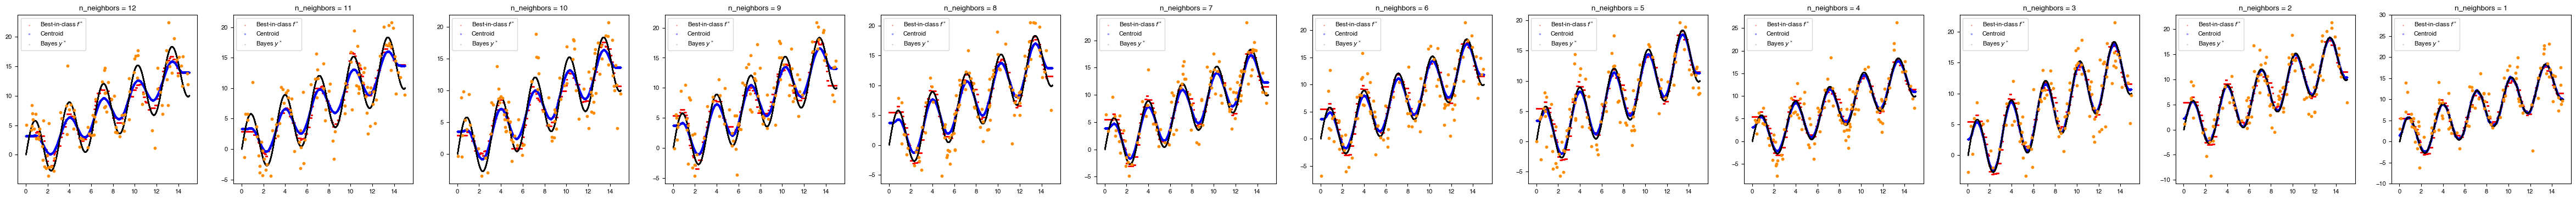

In [19]:

##############################################

plotit = True

##############################################

if plotit: fig, axs = plt.subplots(1, numParams, figsize=(numParams*5,4))

print(xParamName)
for thisParam in range(len(xParams)):

    print(xParams[thisParam], " ", end="")

    Ef = centroid()
    
    for thisTrial in range(numTrials):
        
        #######################################

        if xParamName=='n':
            sampleX, sampleY = getSample( n = xParams[thisParam] )
        else:
            sampleX, sampleY = getSample( n = 100 )
            ferm_model = deepcopy( ferm_model.set_params( **{ xParamName: xParams[thisParam] } ) )
            fhat_model = deepcopy( fhat_model.set_params( **{ xParamName: xParams[thisParam] } ) )

        #######################################
        
        #Calculate the f_erm ...or the best we can do anyway
        ferm = deepcopy(ferm_model).fit( sampleX, sampleY )

        Risk_ferm[thisParam,thisTrial] = mean_squared_error(ferm.predict(PX), PY)
        
        #######################################
        
        #If the risk of this fstar is the min so far, then take it, otherwise, keep the best
        #
        minsofar = min(Risk_fstar) #use if I want minsofar across all params up to now
        #
        #minsofar = Risk_fstar[thisParam] #use if I want minsofar across trials - just within this parameter)
        
        if Risk_ferm[thisParam,thisTrial] < minsofar:
            fstar = deepcopy(ferm)
        
        Risk_fstar[thisParam] = min( Risk_ferm[thisParam,thisTrial], minsofar )

        #######################################
        
        #Build and plot a sub-optimal fhat that is not necessarily the ERM
        fhat = deepcopy(fhat_model).fit( sampleX, sampleY )
        #Or just assume fhat=ferm
        #fhat = ferm
        
        Risk_fhat[thisParam,thisTrial] = mean_squared_error(fhat.predict(PX), PY)
        
        #PRETTY, BUT TAKES A LONG TIME TO RENDER/PLOT
        #if plotit: axs[thisParam].plot( PX, fhat.predict(PX), color="blue", alpha=0.003, linewidth=1)

        #Add \hat{f} to the centroid
        Ef.add( fhat )

    #endfor thisTrial
        
    ###################################

    #Calculate the risk of E[fhat], i.e. the risk of the centroid
    Risk_Efhat[thisParam] = mean_squared_error(Ef.predict(PX), PY)

    #Calculate the expected risks of fhat/ferm
    ERisk_fhat[thisParam] = np.mean( Risk_fhat[thisParam,:] )
    ERisk_ferm[thisParam] = np.mean( Risk_ferm[thisParam,:] )
    
    #Calculate the risk components
    optim[thisParam]     = ( ERisk_fhat[thisParam] - ERisk_ferm[thisParam] )
    estim[thisParam]     = ( ERisk_ferm[thisParam] - Risk_fstar[thisParam] )
    approx[thisParam]    = ( Risk_fstar[thisParam] - R_ystar )
    bayes[thisParam]     = ( R_ystar )
    estimvar[thisParam]  = ( ERisk_ferm[thisParam] - Risk_Efhat[thisParam] )
    estimbias[thisParam] = ( Risk_Efhat[thisParam] - Risk_fstar[thisParam] )
   
    ###################################
    
    #Plot f^*, EF, and y^*
    #if plotit: axs[thisParam].plot( PX, fstar.predict(PX), color="red", linewidth=1, label='Best-in-class $f^*$')
    #if plotit: axs[thisParam].plot( PX, Ef.predict(PX),    color="blue", linewidth=2, label='Centroid')
    #if plotit: axs[thisParam].plot( PX, trueFunction(PX),  color="black", linewidth=1, label='Bayes $g$')
    
    #Plot f^*, EF, and y^*
    if plotit: axs[thisParam].scatter( PX, fstar.predict(PX), s=0.1, color="red", linewidth=1, label='Best-in-class $f^*$')
    if plotit: axs[thisParam].scatter( PX, Ef.predict(PX),    s=0.1, color="blue", linewidth=2, label='Centroid')    
    if plotit: axs[thisParam].scatter( PX, trueFunction(PX), color="black", s=0.1, marker='.', label='Bayes $y^*$')

    #Plot sample training points
    if plotit: axs[thisParam].scatter(sampleX, sampleY, s=10, c="darkorange")
    if plotit: axs[thisParam].set_title(xParamName+' = '+str(xParams[thisParam]))
    if plotit: axs[thisParam].legend()
    if plotit: plt.ylim([-10,30])

#endfor thisParam


In [20]:
def doFormatting(whereToPlot, xParams, ylim=[-3,40]):

    #whereToPlot.set_ylim( ylim )
    
    if xParams[0] > xParams[-1]:
        #x-axis is in descending order
        whereToPlot.set_xlim( xParams[0]+0.5 , xParams[-1]-0.5 )
    else:
        #x-axis is in ascending order
        whereToPlot.set_xlim( xParams[0]-0.5 , xParams[-1]+1 )
     
    whereToPlot.set_xticks(ticks=list(xParams))
    whereToPlot.set_xlabel(xParamName, fontsize=15)
    

    whereToPlot.axhline(linewidth=2, color="k", linestyle=":")
    whereToPlot.axvline(linewidth=2, color="k", linestyle=":")
    #whereToPlot.legend(loc='upper left', fontsize="8")
    whereToPlot.tick_params(axis='both', which='major', labelsize=12)
    #whereToPlot.legend(bbox_to_anchor=(1.2, 1), loc='upper left', ncol=1, fontsize="8")

    whereToPlot.grid(True)
    whereToPlot.grid(which = "major")

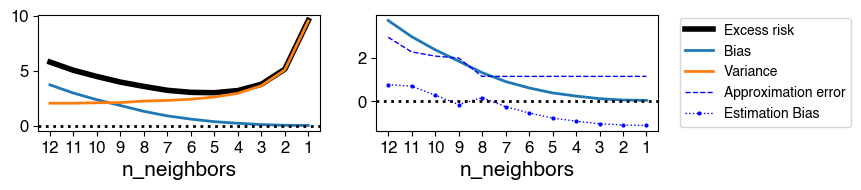

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(2*4,1.5))

####################################################################################################
whereToPlot = axs[0]
####################################################################################################
whereToPlot.plot(xParams, (ERisk_fhat - bayes), label='Excess risk', color='black', linewidth=4)
whereToPlot.plot(xParams, np.add(approx,estimbias), label='Bias', linewidth=2)
whereToPlot.plot(xParams, np.add(optim, estimvar),  label='Variance', linewidth=2)
#whereToPlot.plot(xParams, bayes, label='Noise', color='red', linewidth=1)
#whereToPlot.plot(xParams,sum(np.array([bayes,approx,estim,optim])), label='Sum', color='yellow', linewidth=1)
#####
doFormatting(whereToPlot, xParams)


####################################################################################################
whereToPlot = axs[1]
####################################################################################################
whereToPlot.plot(xParams, np.add(approx,estimbias), label='_Bias', linewidth=2) #the underscore hides this label
whereToPlot.plot(xParams, approx, label='Approximation error', color='blue',   linewidth=1, linestyle="--")
whereToPlot.plot(xParams, estimbias, label='Estimation Bias', color='blue', linestyle=':', linewidth=1, marker='o', markersize=2)
#####

doFormatting(whereToPlot, xParams, ylim=[-10,30])

fig.legend(loc='upper right', bbox_to_anchor=(1.15, 0.91), fontsize="10" )
